In [ ]:
!pip install --upgrade pip
!pip install pymap3d==2.1.0
!pip install -U l5kit
!pip3 install resnet_pytorch

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import pandas as pd

from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset

from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
from l5kit.geometry import transform_points
from tqdm import tqdm
from collections import Counter
from l5kit.data import PERCEPTION_LABELS
from prettytable import PrettyTable

import os
import warnings
warnings.filterwarnings('ignore')
from matplotlib import animation, rc
from IPython.display import HTML, display

rc('animation', html='jshtml')

In [ ]:
IMG_SIZE = 224
# Lyft configuration
cfg = {
          'model_params': {'model_architecture': 'LSTM',
          'history_num_frames': 10,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1,
        'model_name': "model_LSTM_output",
        'lr': 1e-4,
        'train': True,
        'predict': True},

        'raster_params': {'raster_size': [IMG_SIZE, IMG_SIZE],
          'pixel_size': [0.5, 0.5],
          'ego_center': [0.25, 0.5],
          'map_type': 'py_semantic',
          'satellite_map_key': 'aerial_map/aerial_map.png',
          'semantic_map_key': 'semantic_map/semantic_map.pb',
          'dataset_meta_key': 'meta.json',
          'filter_agents_threshold': 0.5},
        "test_data_loader":{
        'key': "scenes/test.zarr",
        'batch_size': 12,
        'shuffle': False,
        'num_workers': 4}
        
    }
print(cfg)

{'model_params': {'model_architecture': 'LSTM', 'history_num_frames': 10, 'history_step_size': 1, 'history_delta_time': 0.1, 'future_num_frames': 50, 'future_step_size': 1, 'future_delta_time': 0.1, 'model_name': 'model_LSTM_output', 'lr': 0.0001, 'train': True, 'predict': True}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5}, 'test_data_loader': {'key': 'scenes/test.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 4}}


In [ ]:
os.environ["L5KIT_DATA_FOLDER"] = "../input/lyft-motion-prediction-autonomous-vehicles"
dm = LocalDataManager(None)

test_zarr = ChunkedDataset(dm.require(cfg['test_data_loader']['key'])).open()
print(test_zarr)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   11314    |  1131400   |  88594921  |    7854144    |      31.43      |        100.00        |        78.31         |        10.00         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [ ]:
# Semantic view
cfg['raster_params']['map_type'] = 'py_semantic'
semantic_rasterizer = build_rasterizer(cfg, dm)

# Satellite view
cfg['raster_params']['map_type'] = 'py_satellite'
satellite_rasterizer = build_rasterizer(cfg, dm)

In [ ]:
df_sub = pd.read_csv('../input/result/submission.csv')
df_sub = df_sub.set_index(['timestamp', 'track_id'])


In [ ]:
display(df_sub.head())

conf_0    conf_1    conf_2  coord_x00  \
timestamp           track_id                                            
1578606007801600134 2         0.502480  0.205125  0.292395   -0.11272   
1578606032802467516 4         0.380652  0.358710  0.260638   -0.63477   
                    5         0.542430  0.093180  0.364390    0.12414   
                    81        0.213896  0.720917  0.065187   -0.25885   
                    130       0.035118  0.953250  0.011632    0.01142   

                              coord_y00  coord_x01  coord_y01  coord_x02  \
timestamp           track_id                                               
1578606007801600134 2           0.22052   -0.22827    0.47644   -0.33984   
1578606032802467516 4          -0.97205   -1.21299   -1.90659   -1.71423   
                    5           0.20155    0.25162    0.38692    0.32335   
                    81         -0.41525   -0.50425   -0.77621   -0.67320   
                    130        -0.00426    0.02232   -0.01539    0.04585   

                              coord_y02  coord_x03  ...  coord_x245  \
timestamp           track_id                        ...               
1578606007801600134 2           0.70938   -0.43328  ...    -3.77350   
1578606032802467516 4          -2.77318   -2.30782  ...   -26.60185   
                    5           0.48188    0.40778  ...    10.76700   
                    81         -1.08616   -0.87364  ...   -14.57502   
                    130        -0.01270    0.07871  ...     7.54189   

                              coord_y245  coord_x246  coord_y246  coord_x247  \
timestamp           track_id                                                   
1578606007801600134 2            9.78203    -3.82382     9.98727    -3.82410   
1578606032802467516 4          -52.09507   -27.16204   -53.32994   -27.69998   
                    5           16.50119    11.21317    17.16004    11.64454   
                    81         -20.05599   -15.00510   -20.66341   -15.39088   
                    130         -4.43858     7.81336    -4.62239     8.11578   

                              coord_y247  coord_x248  coord_y248  coord_x249  \
timestamp           track_id                                                   
1578606007801600134 2           10.14358    -3.88177    10.32704    -3.87213   
1578606032802467516 4          -54.54478   -28.31844   -55.75174   -28.86150   
                    5           17.80387    12.13832    18.50339    12.60096   
                    81         -21.26982   -15.94496   -21.88746   -16.43359   
                    130         -4.74680     8.38060    -4.95114     8.63848   

                              coord_y249  
timestamp           track_id              
1578606007801600134 2           10.43912  
1578606032802467516 4          -56.90025  
                    5           19.16411  
                    81         -22.46411  
                    130         -5.09262  

[5 rows x 303 columns]

In [ ]:
def row_to_confs(row):
    return [row[f'conf_{i}'] for i in range(3)]
def row_to_coords(row):
    return row[3:].values.reshape(3, 50, 2)

In [ ]:
semantic_dataset = EgoDataset(cfg, test_zarr, semantic_rasterizer)
satellite_dataset = EgoDataset(cfg, test_zarr, satellite_rasterizer)
test_mask = np.load(f"../input/lyft-motion-prediction-autonomous-vehicles/scenes/mask.npz")["arr_0"]
agent_semantic_dataset = AgentDataset(cfg, test_zarr, semantic_rasterizer, agents_mask=test_mask)
agent_satellite_dataset = AgentDataset(cfg, test_zarr, satellite_rasterizer, agents_mask=test_mask)

In [ ]:
cmap = plt.get_cmap("tab10")
matplotlib_colors_in_rgb_int = [[int(255 * x) for x in cmap(i)[:3]] for i in range(10)]

In [ ]:
raster_params = cfg['raster_params']
raster_from_agent = np.array([
    [2., 0.,  56.],
    [0., 2., 112.],
    [0., 0.,   1.],
]) if (
    raster_params['raster_size'] == [224, 224] and
    raster_params['pixel_size'] == [0.5, 0.5] and
    raster_params['ego_center'] == [0.25, 0.5]
) else None
    
def generate_image_trajectory(dataset, index):
    data = dataset[index]
    im = data['image'].transpose(1, 2, 0)
    im = dataset.rasterizer.to_rgb(im)
    rfg = raster_from_agent if raster_from_agent is not None else data['raster_from_agent']
    target_positions_pixels = transform_points(data['target_positions'], rfg)
    draw_trajectory(im, target_positions_pixels, yaws=data['target_yaws'], rgb_color=TARGET_POINTS_COLOR)
    return im

def plot_trajectory(dataset, indices, width=12, height=4, n_cols=4, title=''):
    if not isinstance(indices, (list, np.ndarray)):
        indices = [indices]
    n_rows = len(indices) // n_cols + len(indices) % n_cols
    plt.figure(figsize=(width, height*n_rows))
    for k, index in enumerate(indices):
        plt.subplot(n_rows, n_cols, 1+k).set_title(str(index))
        im = generate_image_trajectory(dataset, index)
        plt.imshow(im, origin='lower')
    if title:
        plt.suptitle(title)
    plt.show()

def generate_image_predicted_trajectory(dataset, df_sub, index):
    data = dataset[index]
    im = data['image'].transpose(1, 2, 0)
    im = dataset.rasterizer.to_rgb(im)
    row = df_sub.loc[(data['timestamp'], data['track_id'])]
    # note submission coordinate system = world - centroid
    predicted_target_positions_in_sub = row_to_coords(row)
    predicted_target_positions_in_world = predicted_target_positions_in_sub + data['centroid']
    for i, coords in enumerate(predicted_target_positions_in_world):
        target_positions_pixels = transform_points(coords, data['raster_from_world'])
        draw_trajectory(im, target_positions_pixels, rgb_color=matplotlib_colors_in_rgb_int[i])
    return im, row_to_confs(row)

def plot_predicted_trajectory(dataset, df_sub, indices, width=12, height=4, n_cols=3, title=''):
    if not isinstance(indices, (list, np.ndarray)):
        indices = [indices]
    n_rows = len(indices) // n_cols + len(indices) % n_cols
    plt.figure(figsize=(width, height*n_rows))
    for k, index in enumerate(indices):
        plt.subplot(n_rows, n_cols, 1+k).set_title(str(index))
        im, confs = generate_image_predicted_trajectory(dataset, df_sub, index)
        patches = [mpatches.Patch(color=cmap(m), label='%.3f'%conf) for m, conf in enumerate(confs)]
        plt.imshow(im, origin='lower')
        plt.legend()
    plt.show()

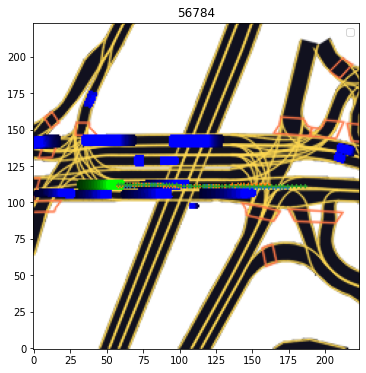

In [ ]:
plot_predicted_trajectory(agent_semantic_dataset, df_sub, [56784], width=6, height=6, n_cols=1)

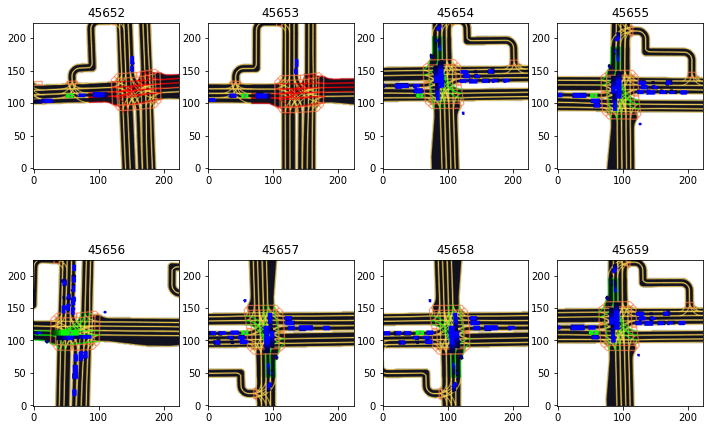

In [ ]:
plot_trajectory(agent_semantic_dataset, list(range(45652, 45652+8)))

In [ ]:
import bisect
def get_scene_index_from_frame_id(dataset, frame_id):
    return bisect.bisect_right(dataset.cumulative_sizes, frame_id)

i_plots = [400]

def animate(images):
    fig = plt.figure()
    ims = [(plt.imshow(im, animated=True, origin='lower'),) for im in images]
    anim = animation.ArtistAnimation(fig, ims, interval=60, blit=True, repeat_delay=1000)
    plt.close()
    return HTML(anim.to_jshtml())

def plot_scene(dataset, scene_id):
    indices = dataset.get_scene_indices(scene_id)
    print('scene', scene_id, ':', indices[0], '-', indices[-1])
    images = [generate_image_trajectory(dataset, i) for i in indices]
    return animate(images)

scene_id = get_scene_index_from_frame_id(semantic_dataset, i_plots[0])

In [ ]:
plot_scene(semantic_dataset, scene_id)

scene 4 : 400 - 499
